In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.integrate import quad_vec
from scipy.special import jv
from time import time as tm
from scipy.special import genlaguerre
from numpy import pi, exp, sqrt
from scipy.special import eval_genlaguerre
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Бесселев пучок на треугольной апертуре

In [7]:
def triangle_vertices_cartesian(L):
    """Вершины равностороннего треугольника со стороной L"""
    R = L / np.sqrt(3)
    return np.array([
        [R * np.cos(0), R * np.sin(0)],
        [R * np.cos(2*np.pi/3), R * np.sin(2*np.pi/3)],
        [R * np.cos(4*np.pi/3), R * np.sin(4*np.pi/3)]
    ])

def point_inside_triangle(x, y, vertices):
    """Проверка принадлежности точки треугольнику"""
    v1, v2, v3 = vertices
    cross1 = (v2[0]-v1[0])*(y-v1[1]) - (v2[1]-v1[1])*(x-v1[0])
    cross2 = (v3[0]-v2[0])*(y-v2[1]) - (v3[1]-v2[1])*(x-v2[0])
    cross3 = (v1[0]-v3[0])*(y-v3[1]) - (v1[1]-v3[1])*(x-v3[0])
    return (cross1 >= 0) == (cross2 >= 0) == (cross3 >= 0)

def angular_part(x, y, m):
    """Вычисляет угловую часть e^{imφ} в декартовых координатах"""
    rho = np.sqrt(x**2 + y**2)
    if m >= 0:
        return (x + 1j*y)**m / (rho**m if m != 0 else 1)
    else:
        return (x - 1j*y)**abs(m) / (rho**abs(m))

def compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m_target, N_samples=100):
    """Вычисление дифракции Бесселя с оптимизацией памяти"""
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)
    x_ap, y_ap = np.meshgrid(np.linspace(x_min, x_max, N_samples),
                            np.linspace(y_min, y_max, N_samples))
    dx = (x_max - x_min) / (N_samples - 1)
    dy = (y_max - y_min) / (N_samples - 1)

    # Маска для точек внутри треугольника
    mask = np.vectorize(point_inside_triangle, excluded=['vertices'])(x_ap, y_ap, vertices=vertices)

    # Вычисления только для точек внутри
    x_p = x_ap[mask]
    y_p = y_ap[mask]

    # Векторизованные вычисления
    R = np.sqrt(z**2 + (X - x_p[:, None, None])**2 + (Y - y_p[:, None, None])**2)
    R = np.where(R < 1e-10, 1e-10, R)  # Избегаем деления на ноль

    kappa = np.sqrt(k**2 - k_z**2)
    angular_part_val = angular_part(x_p, y_p, m_target)
    bessel_part = jv(abs(m_target), kappa * np.sqrt(x_p**2 + y_p**2))
    exp_part = np.exp(1j * k * R)
    factor = (1j*k - 1/R) * z/R + 1j*k_z

    psi = np.sum(bessel_part[:, None, None] * angular_part_val[:, None, None] * exp_part * factor / (4 * np.pi * R) * dx * dy, axis=0)

    return np.abs(psi)**2

In [8]:
# Параметры расчета
me = 0.511e6           # масса электрона (эВ)
E_k = 100e3            # кинетическая энергия (эВ)

#Релятивизм/полурелятивизм
E = 1 + E_k / me       # полная энергия
#k = sqrt(E**2 - 1)     # волновой вектор

#Не релятивизм
k = sqrt(2*E_k/me)

lambda_e = (2*pi)/k     # длина волны де Бройля для E_k
theta = 0.00001         # угол раствора (рад)
k_z = k * np.cos(theta) # продольная компонента волнового вектора
kappa_2 = k * theta

lambda_c = 386e-15     # комптоновская длина волны (м)

L = 1e6                # размер апертуры
z = 1e12               # расстояние до экрана
b = 1e8                # размер расчетной области
N_xy = 100             # число точек в сетке наблюдения
N_samples = 100        # число точек интегрирования по апертуре

# Сетка наблюдения
x = np.linspace(-b, b, N_xy)
y = np.linspace(-b, b, N_xy)
X, Y = np.meshgrid(x, y)
print(1/kappa_2)
print(k*me*1e-6)
print(kappa_2*0.511e6)
print(lambda_e*lambda_c)

D = L/sqrt(3)       # размер апертуры

# Граница зон Френеля-Фраунгофера
z_fraunhofer = (D**2) / (lambda_e)
print(D*lambda_c*1e9)
print(z_fraunhofer*1e-9)

159843.67363145782
0.31968734726291553
3.196873472629156
3.87670384740219e-12
222.85720390719555
33.18970747607848


0.0
159843.732679715
799218.663398575
-799218.663398575
1598437.32679715


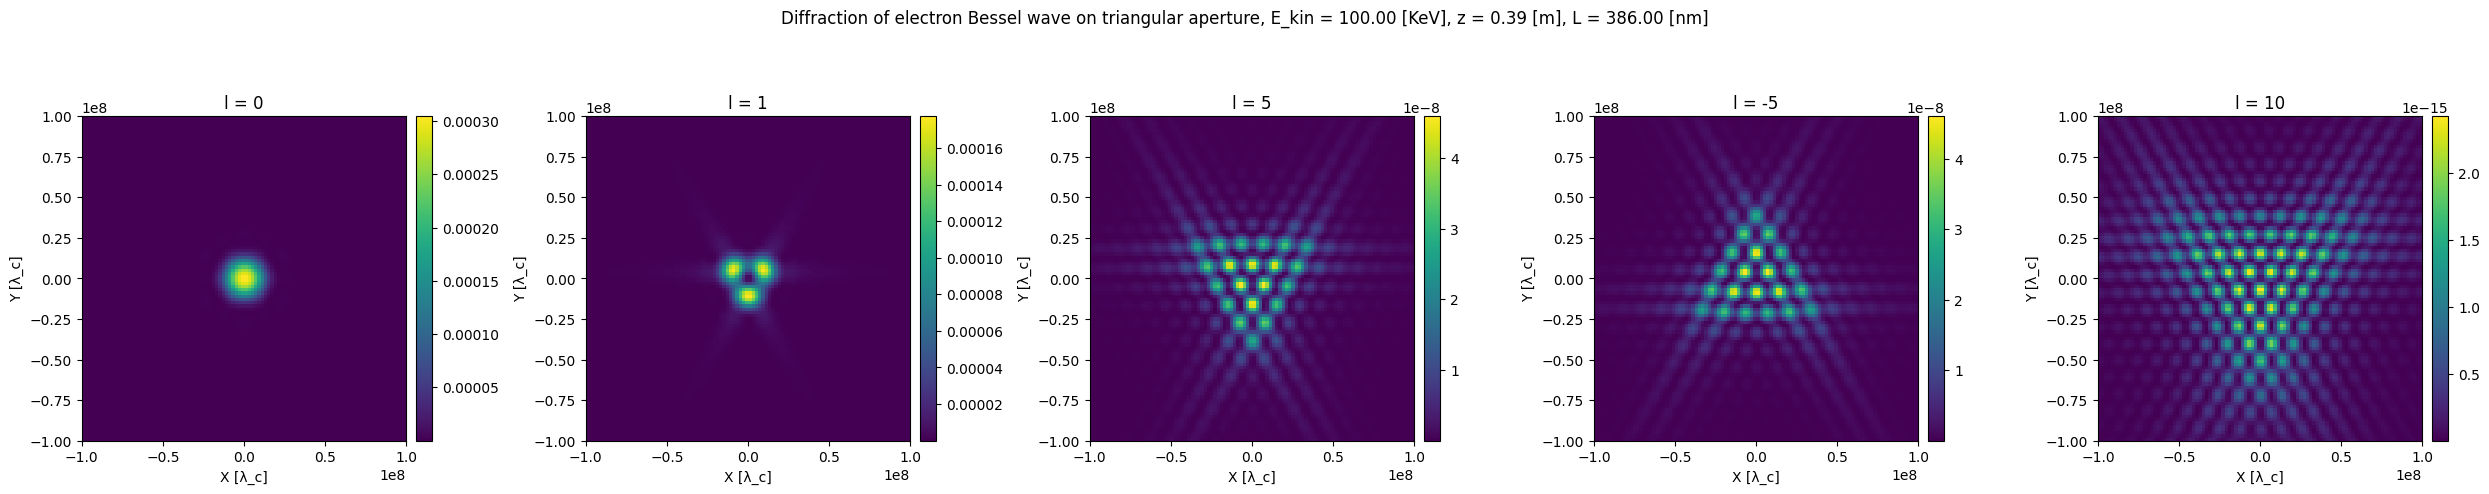

In [9]:
# Вершины треугольника
vertices = triangle_vertices_cartesian(L)

# Расчет для разных значений топологического заряда
m_values = [0, 1, 5, -5, 10]

fig, axes = plt.subplots(1, len(m_values), figsize=(25, 5))
fig.suptitle(f'Diffraction of electron Bessel wave on triangular aperture, E_kin = {E_k/1e3:.2f} [KeV], z = {z*386e-15:.2f} [m], L = {L*386e-6:.2f} [nm]', y=1.01)
for idx, m in enumerate(m_values):
    ax  = axes[idx]
    intensity = compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m, N_samples)
    im = axes[idx].imshow(intensity, extent=[-b, b, -b, b], cmap='viridis')
    axes[idx].set_title(f"l = {m}")
    axes[idx].set_xlabel("X [λ_с]")
    axes[idx].set_ylabel("Y [λ_с]")
    ax.set_aspect('equal')
    # Создаем colorbar для конкретного Axes
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # 5 % ширины оси, зазор 0.05
    fig.colorbar(im, cax=cax)
    print(m/np.sqrt(k**2 - k_z**2))

plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Параметры сохранения
output_dir = "bessel_triangle_diffraction"  # Папка для сохранения
os.makedirs(output_dir, exist_ok=True)  # Создаем папку, если ее нет
dpi = 300  # Разрешение изображений
format = 'png'  # Формат файла (можно изменить на 'pdf', 'svg')

# Размеры отдельных графиков (в дюймах)
single_figsize = (8, 6)

# Вершины треугольника
vertices = triangle_vertices_cartesian(L)

# Значения топологического заряда
m_values = [0, 1, 5, -5, 10]

for idx, m in enumerate(m_values):
    # Создаем отдельную фигуру
    fig, ax = plt.subplots(figsize=single_figsize)

    # Вычисляем интенсивность
    intensity = compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m, N_samples)

    # Визуализация
    im = ax.imshow(intensity,
                  extent=[-b, b, -b, b],
                  cmap='viridis',
                  origin='lower')

    # Настройки графика
    ax.set_title(f"Bessel beam, $\ell$ = {m}", fontsize=14)
    ax.set_xlabel("X position ", fontsize=12)
    ax.set_ylabel("Y [λ$_c$]", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_aspect('equal')

    # Цветовая шкала
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Intensity', fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    # Улучшаем компоновку
    plt.tight_layout()

    # Формируем имя файла
    filename = f"Bessel_triangle_l_{m}_E_{E_k/1e3:.0f}keV_z_{z*386e-15:.2f}m_L_{L*386e-6:.2f}nm.{format}"
    filepath = os.path.join(output_dir, filename)

    # Сохраняем
    plt.savefig(filepath, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    plt.close()  # Закрываем фигуру

print(f"Сохранено {len(m_values)} изображений в папку '{output_dir}'")

<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/var/folders/v2/myrvw3_n5fx9f2t0_b_7g9tr0000gn/T/ipykernel_56751/2981930962.py:35: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f"Bessel beam, $\ell$ = {m}", fontsize=14)


Сохранено 5 изображений в папку 'bessel_triangle_diffraction'


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Параметры сохранения
output_dir = "bessel_triangle_zones"  # Папка для сохранения
os.makedirs(output_dir, exist_ok=True)  # Создаем папку, если ее нет
dpi = 300  # Разрешение изображений
format = 'png'  # Формат файла (можно изменить на 'pdf', 'svg')

# Размеры отдельных графиков (в дюймах)
single_figsize = (8, 6)

# Параметры для 5 зон (исключая первую ближнюю зону)
zones = [
    {"z": 0.1 * z_fraunhofer, "b_scale": 0.3, "label": "Near Field (0.1z_F)"},
    {"z": 0.3 * z_fraunhofer, "b_scale": 0.5, "label": "Transition zone (0.3z_F)"},
    {"z": z_fraunhofer, "b_scale": 1.0, "label": "Fraunhofer (z_F)"},
    {"z": 5 * z_fraunhofer, "b_scale": 5.0, "label": "Far Field (5z_F)"},
    {"z": 100 * z_fraunhofer, "b_scale": 100.0, "label": "Far Field (100z_F)"}
]

# Целевой топологический заряд
m_target = 2
N_xy = 100
N_samples = 100

# Вершины треугольника
vertices = triangle_vertices_cartesian(L)

for idx, zone in enumerate(zones):
    z = zone["z"]
    b = zone["b_scale"] * 5e6  # Масштабируем базовый размер области

    # Сетка наблюдения
    x = np.linspace(-b, b, N_xy)
    y = np.linspace(-b, b, N_xy)
    X, Y = np.meshgrid(x, y)

    # Расчет интенсивности
    intensity = compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m_target, N_samples)

    # Создаем отдельную фигуру
    fig, ax = plt.subplots(figsize=single_figsize)

    # Визуализация
    im = ax.imshow(intensity,
                  extent=[-b, b, -b, b],
                  cmap='viridis',
                  origin='lower')

    # Настройки графика
    ax.set_title(f"Bessel beam ($\ell$={m_target}) - {zone['label']}", fontsize=14)
    ax.set_xlabel("X position (pm)", fontsize=12)
    ax.set_ylabel("Y position (pm)", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Цветовая шкала
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Intensity', fontsize=11)
    cbar.ax.tick_params(labelsize=9)

    # Улучшаем компоновку
    plt.tight_layout()

    # Формируем имя файла
    filename = f"Bessel_triangle_l_{m_target}_zone_{idx+1}_z_{z*386e-15:.2e}m.{format}"
    filepath = os.path.join(output_dir, filename)

    # Сохраняем
    plt.savefig(filepath, dpi=dpi, bbox_inches='tight', pad_inches=0.1)
    plt.close()  # Закрываем фигуру

print(f"Сохранено {len(zones)} изображений в папку '{output_dir}'")

<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:54: SyntaxWarning: invalid escape sequence '\e'
/var/folders/v2/myrvw3_n5fx9f2t0_b_7g9tr0000gn/T/ipykernel_56751/1939656686.py:54: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f"Bessel beam ($\ell$={m_target}) - {zone['label']}", fontsize=14)


Сохранено 5 изображений в папку 'bessel_triangle_zones'


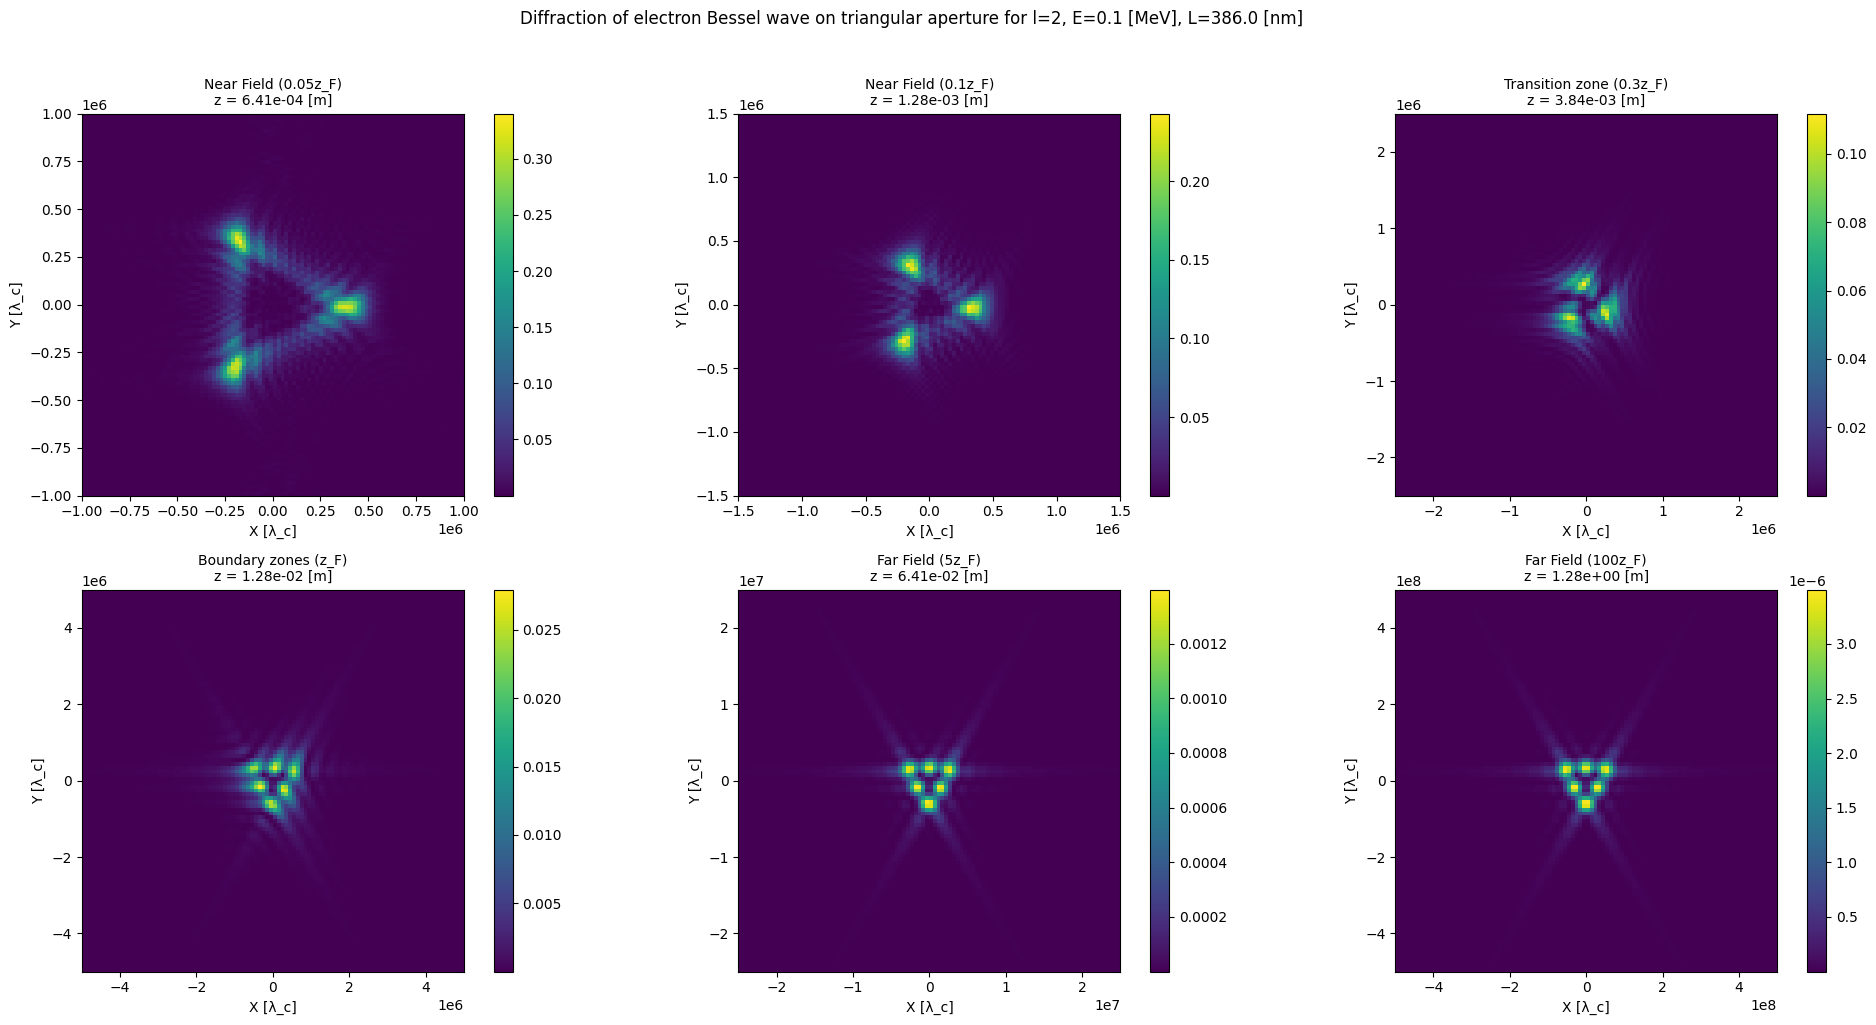

In [12]:
# Параметры для 6 зон
zones = [
    {"z": 0.05 * z_fraunhofer, "b_scale": 0.2, "label": "Near Field (0.05z_F)"},
    {"z": 0.1 * z_fraunhofer, "b_scale": 0.3, "label": "Near Field (0.1z_F)"},
    {"z": 0.3 * z_fraunhofer, "b_scale": 0.5, "label": "Transition zone (0.3z_F)"},
    {"z": z_fraunhofer, "b_scale": 1.0, "label": "Boundary zones (z_F)"},
    {"z": 5 * z_fraunhofer, "b_scale": 5.0, "label": "Far Field (5z_F)"},
    {"z": 100 * z_fraunhofer, "b_scale": 100.0, "label": "Far Field (100z_F)"},

]

# Расчет для m=2
m_target = 2
N_xy = 100
N_samples = 100

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()

for idx, zone in enumerate(zones):
    z = zone["z"]
    b = zone["b_scale"] * 5e6  # Масштабируем базовый размер области

    # Сетка наблюдения
    x = np.linspace(-b, b, N_xy)
    y = np.linspace(-b, b, N_xy)
    X, Y = np.meshgrid(x, y)

    # Вершины треугольника
    vertices = triangle_vertices_cartesian(L)

    # Расчет интенсивности
    intensity = compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m_target, N_samples)

    # Визуализация
    im = axes[idx].imshow(intensity, extent=[-b, b, -b, b], cmap='viridis')
    axes[idx].set_title(f"{zone['label']}\nz = {z*386e-15:.2e} [m]", fontsize=10)
    axes[idx].set_xlabel("X [λ_c]")
    axes[idx].set_ylabel("Y [λ_c]")
    plt.colorbar(im, ax=axes[idx])

# Скрываем последний пустой subplot
for i in range(len(zones), len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Diffraction of electron Bessel wave on triangular aperture for l={m_target}, E={E_k/1e6:.1f} [MeV], L={L*lambda_c*1e9:.1f} [nm]', y=1.02)
plt.tight_layout()
plt.show()

# Лагерр-Гауссов пучок на треугольной апертуре

In [13]:
def triangle_vertices_cartesian(L):
    """Вершины равностороннего треугольника со стороной L"""
    R = L / np.sqrt(3)
    return np.array([
        [R * np.cos(0),           R * np.sin(0)],
        [R * np.cos(2*np.pi/3),   R * np.sin(2*np.pi/3)],
        [R * np.cos(4*np.pi/3),   R * np.sin(4*np.pi/3)]
    ])

# --- Быстрая функция для Лагерр–ГАУССОВА дифракции с векторной маской ---
def compute_lg_diffraction_fast(vertices, X, Y, z, k, k_z,
                                m, n, w0, zR, N_int=100):
    # 1) сетка апертуры
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)
    xs = np.linspace(x_min, x_max, N_int)
    ys = np.linspace(y_min, y_max, N_int)
    x_ap, y_ap = np.meshgrid(xs, ys, indexing='ij')

    # 2) векторная маска внутри треугольника
    v1, v2, v3 = vertices
    cross1 = (v2[0]-v1[0])*(y_ap-v1[1]) - (v2[1]-v1[1])*(x_ap-v1[0])
    cross2 = (v3[0]-v2[0])*(y_ap-v2[1]) - (v3[1]-v2[1])*(x_ap-v2[0])
    cross3 = (v1[0]-v3[0])*(y_ap-v3[1]) - (v1[1]-v3[1])*(x_ap-v3[0])
    mask = ((cross1>=0)&(cross2>=0)&(cross3>=0)) | ((cross1<=0)&(cross2<=0)&(cross3<=0))

    x_p = x_ap[mask]
    y_p = y_ap[mask]
    P   = x_p.size

    # шаги интегрирования
    dx = (x_max - x_min) / (N_int - 1)
    dy = (y_max - y_min) / (N_int - 1)
    area_weight = dx * dy
    fourpi = 4*np.pi

    # 3) пред-вычисления
    rho_p = np.hypot(x_p, y_p)
    phi_p = np.arctan2(y_p, x_p)

    # угловая часть
    if m >= 0:
        angular = (x_p + 1j*y_p)**m / (rho_p**m if m != 0 else 1)
    else:
        angular = (x_p - 1j*y_p)**abs(m) / (rho_p**abs(m))

    # радиальная часть и гаусс
    radial = (rho_p / w0)**abs(m) * eval_genlaguerre(n, abs(m), 2*rho_p**2 / w0**2)
    gauss  = np.exp(-rho_p**2 / w0**2)

    # поперечная амплитуда на апертуре
    Psi0 = radial * angular * gauss * area_weight

    # коэффициент градиентного слагаемого
    grad_coeff = 1j * (k * rho_p**2 / (2 * zR**2) + k_z - (2*n + abs(m) + 1) / zR)

    # 4) интегрирование по точкам апертуры
    psi = np.zeros_like(X, dtype=complex)
    for idx in range(P):
        xp, yp = x_p[idx], y_p[idx]
        psi0   = Psi0[idx]
        grad0  = grad_coeff[idx] * psi0

        R = np.sqrt((X - xp)**2 + (Y - yp)**2 + z**2)
        K = np.exp(1j * k * R) / (fourpi * R)

        surf = psi0 * (1j * k - 1/R) * (z / R)
        psi += K * (surf + grad0)

    return psi

In [14]:
# ------------------ параметры расчёта ------------------
me = 0.511e6           # масса электрона (эВ)
E_k = 100e3             # кинетическая энергия (эВ)
E = 1 + E_k / me
k = np.sqrt(E**2 - 1)
theta = 0.0001             # угол рассхода
k_z = k * np.cos(theta)
w0 = 1e6               # ширина пучка
zR = np.pi * w0**2 / k # длина Рэлея
n_values = [0, 5]            # радиальный порядок
m_targets= [0, 1, 5, -5, 10]  # топологический заряд l=m
N_int = 100               # число точек интегрирования
N_xy = 100               # число точек наблюдения
z = 1e12              # расстояние до экрана
b = 1e8               # размер области наблюдения
L = 1e6               # размер апертуры
lambda_c = 386e-15           # комптоновская длина волны

# vertices апертуры
vertices = triangle_vertices_cartesian(L)

# сетка наблюдения
x = np.linspace(-b, b, N_xy)
y = np.linspace(-b, b, N_xy)
X, Y = np.meshgrid(x, y, indexing='ij')
print(lambda_e*lambda_c)

3.87670384740219e-12


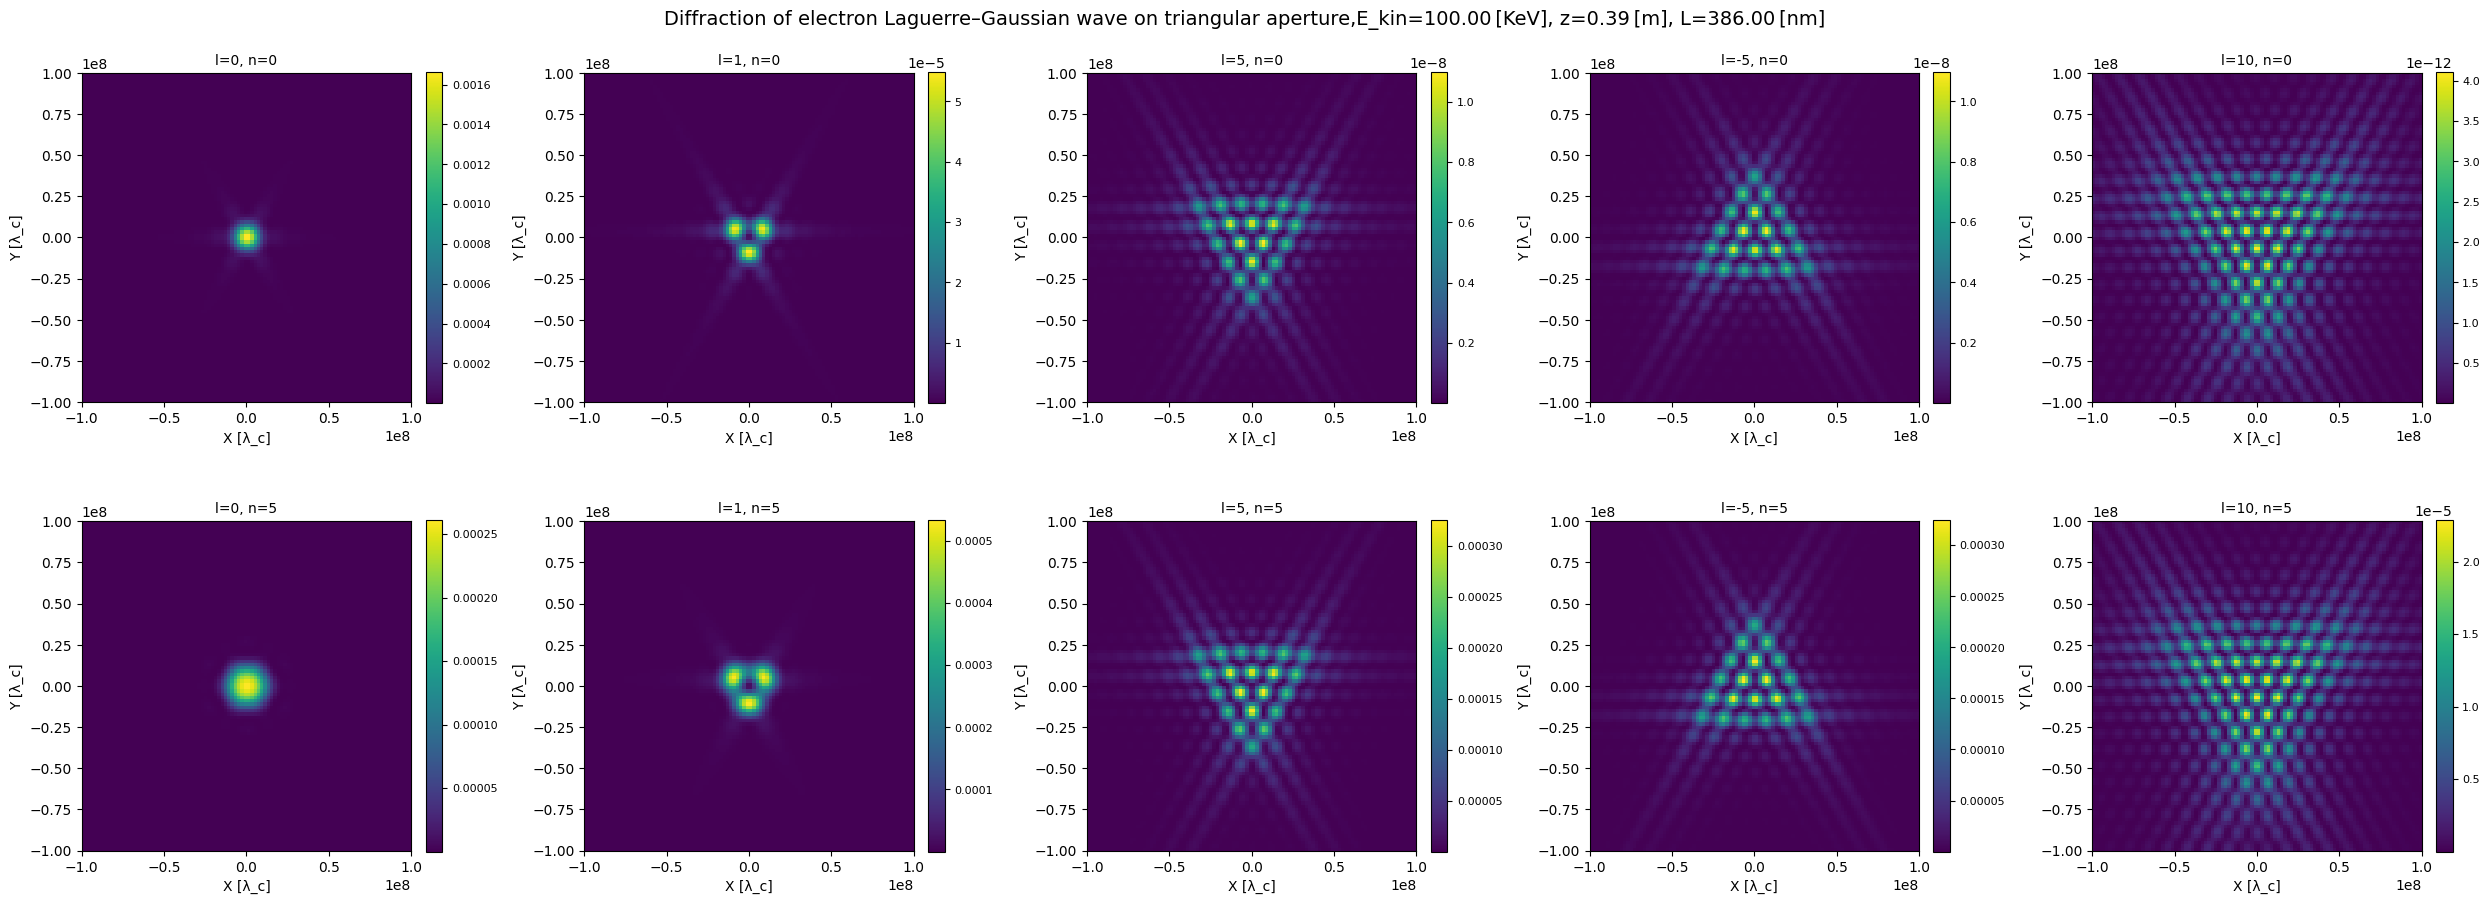

In [15]:
# ---- Визуализация ----
rows, cols = len(n_values), len(m_targets)
fig, axes = plt.subplots(rows, cols, figsize=(25, 5*rows))
axes = np.atleast_2d(axes)
fig.suptitle(
    f"Diffraction of electron Laguerre–Gaussian wave on triangular aperture,"
    f"E_kin={E_k/1e3:.2f} [KeV], z={z*lambda_c:.2f} [m], L={L*lambda_c*1e9:.2f} [nm]",
    fontsize=14,
    y=0.92
)

for i, n in enumerate(n_values):
  for j, m in enumerate(m_targets):
    psi = compute_lg_diffraction_fast(vertices, X, Y, z, k, k_z, m, n, w0, zR, N_int)
    intensity = np.abs(psi)**2

    ax = axes[i, j]
    im = ax.imshow(intensity.T, extent=[-b, b, -b, b], cmap='viridis')
    ax.set_title(f"l={m}, n={n}", fontsize=10)
    ax.set_xlabel("X [λ_c]")
    ax.set_ylabel("Y [λ_c]")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

fig.tight_layout(rect=[0,0,1,0.95])
plt.show()

# Бесселев пучок на равнобедренном треугольник

In [16]:
from math import sqrt, cos, radians
def triangle_vertices(L_base, apex_angle=90):
    theta = radians(apex_angle)
    height = (L_base/2) * np.tan(theta/2)
    return np.array([
        [0, -L_base/2],    # Левая точка
        [height, 0],       # Вершина
        [0, L_base/2]      # Правая точка
    ])

def point_inside_triangle(x, y, vertices):
    """Универсальная проверка принадлежности точки треугольнику через барицентрические координаты"""
    v1, v2, v3 = vertices

    # Векторы вершин
    d1 = np.array(v2) - np.array(v1)
    d2 = np.array(v3) - np.array(v1)

    # Вычисление барицентрических координат
    a = ((v3[1] - v1[1])*(x - v1[0]) + (v1[0] - v3[0])*(y - v1[1])) / \
        ((v3[1] - v1[1])*(v2[0] - v1[0]) + (v1[0] - v3[0])*(v2[1] - v1[1]))
    b = ((v1[1] - v2[1])*(x - v1[0]) + (v2[0] - v1[0])*(y - v1[1])) / \
        ((v3[1] - v1[1])*(v2[0] - v1[0]) + (v1[0] - v3[0])*(v2[1] - v1[1]))
    c = 1 - a - b

    return a >= 0 and b >= 0 and c >= 0

# Остальные функции остаются без изменений
def angular_part(x, y, m):
    """Вычисляет угловую часть e^{imφ} в декартовых координатах"""
    rho = np.sqrt(x**2 + y**2)
    if m >= 0:
        return (x + 1j*y)**m / (rho**m if m != 0 else 1)
    else:
        return (x - 1j*y)**abs(m) / (rho**abs(m))

def compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m_target, N_samples=100):
    """Вычисление дифракции Бесселя (аналогично предыдущей версии)"""
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)
    x_ap, y_ap = np.meshgrid(np.linspace(x_min, x_max, N_samples),
                            np.linspace(y_min, y_max, N_samples))
    dx = (x_max - x_min) / (N_samples - 1)
    dy = (y_max - y_min) / (N_samples - 1)

    mask = np.vectorize(point_inside_triangle, excluded=['vertices'])(x_ap, y_ap, vertices=vertices)
    x_p = x_ap[mask]
    y_p = y_ap[mask]

    R = np.sqrt(z**2 + (X - x_p[:, None, None])**2 + (Y - y_p[:, None, None])**2)
    R = np.where(R < 1e-10, 1e-10, R)

    kappa = np.sqrt(k**2 - k_z**2)
    angular_part_val = angular_part(x_p, y_p, m_target)
    bessel_part = jv(abs(m_target), kappa * np.sqrt(x_p**2 + y_p**2))
    exp_part = np.exp(1j * k * R)
    factor = (1j*k - 1/R) * z/R + 1j*k_z

    psi = np.sum(bessel_part[:, None, None] * angular_part_val[:, None, None] *
           exp_part * factor / (4 * np.pi * R) * dx * dy, axis=0)

    return np.abs(psi)**2

In [17]:
# Параметры расчета
me = 0.511e6           # масса электрона (эВ)
E_k = 300e3            # кинетическая энергия (эВ)
E = 1 + E_k / me       # полная энергия
k = sqrt(E**2 - 1)     # волновой вектор
theta = 0.0001         # угол раствора (рад)
k_z = k * np.cos(theta) # продольная компонента волнового вектора
kappa_2 = k * theta

apex_angle = 90  # Угол при вершине в градусах
L_base = 1e4     # Основание треугольника

L = 1e5                # размер апертуры
z = 1e13               # расстояние до экрана
b = 5e10                # размер расчетной области
N_xy = 100             # число точек в сетке наблюдения
N_samples = 100        # число точек интегрирования по апертуре

# Сетка наблюдения
x = np.linspace(-b, b, N_xy)
y = np.linspace(-b, b, N_xy)
X, Y = np.meshgrid(x, y)
print(1/kappa_2)
print(kappa_2*0.511e6)
print(L*386e-15)
print(k*0.511e6)

8114.178273675306
62.97618597533515
3.86e-08
629761.8597533514


0.0
8114.178316454639
40570.891582273194
-40570.891582273194
81141.78316454639


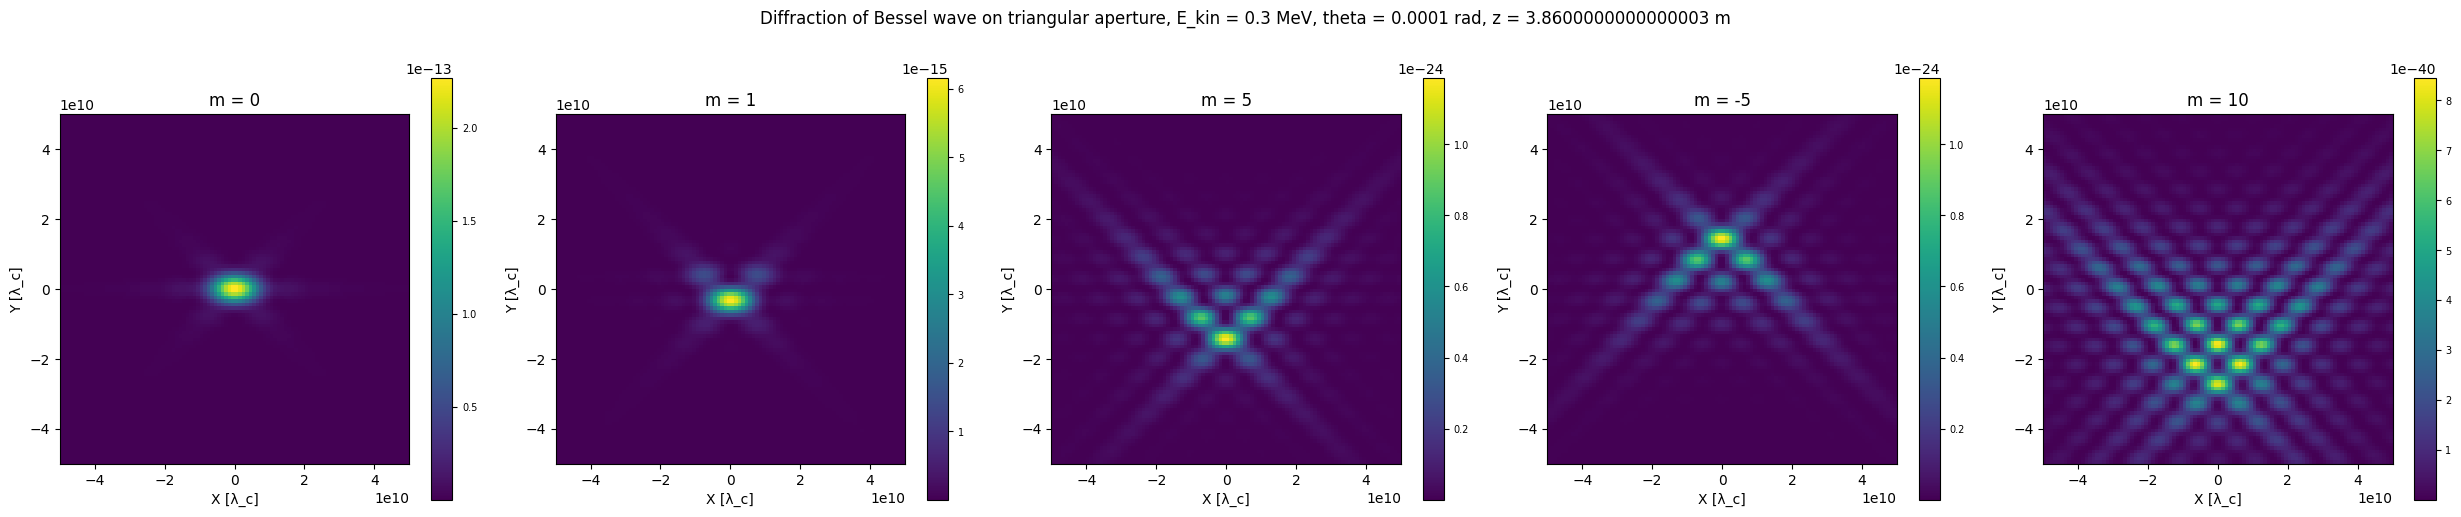

In [18]:
# Вершины треугольника
vertices = triangle_vertices(L_base, apex_angle=90)

# Расчет для разных значений топологического заряда
m_values = [0, 1, 5, -5, 10]

fig, axes = plt.subplots(1, len(m_values), figsize=(25, 5))
fig.suptitle(f'Diffraction of Bessel wave on triangular aperture, E_kin = {E_k/1e6} MeV, theta = {theta} rad, z = {z*386e-15} m', y=1.01)
for idx, m in enumerate(m_values):
    intensity = compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m, N_samples)
    im = axes[idx].imshow(intensity, extent=[-b, b, -b, b], cmap='viridis')
    axes[idx].set_title(f"m = {m}")
    axes[idx].set_xlabel("X [λ_с]")
    axes[idx].set_ylabel("Y [λ_с]")
    # Создаем colorbar для конкретного Axes
    cbar = fig.colorbar(im, ax=axes[idx])
    cbar.ax.tick_params(labelsize=7)
    print(m/np.sqrt(k**2 - k_z**2))

plt.tight_layout()
plt.show()


#Бесселев пучок на прямоугольнике

In [19]:
def rectangle_vertices(width, height):
    """Возвращает вершины прямоугольника с центром в (0,0)"""
    return np.array([
        [-width/2, -height/2],  # Левый нижний
        [ width/2, -height/2],  # Правый нижний
        [ width/2,  height/2],  # Правый верхний
        [-width/2,  height/2]   # Левый верхний
    ])

def point_inside_rectangle(x, y, vertices):
    """Проверка принадлежности точки прямоугольнику"""
    x_min, y_min = np.min(vertices[:,0]), np.min(vertices[:,1])
    x_max, y_max = np.max(vertices[:,0]), np.max(vertices[:,1])
    return (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)

def angular_part(x, y, m):
    """Вычисляет угловую часть e^{imφ} в декартовых координатах"""
    rho = np.sqrt(x**2 + y**2)
    if m >= 0:
        return (x + 1j*y)**m / (rho**m if m != 0 else 1)
    else:
        return (x - 1j*y)**abs(m) / (rho**abs(m))

def compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m_target, N_samples=100):
    """Вычисление дифракции Бесселя для прямоугольной апертуры"""
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)

    x_ap, y_ap = np.meshgrid(np.linspace(x_min, x_max, N_samples),
                            np.linspace(y_min, y_max, N_samples))
    dx = (x_max - x_min) / (N_samples - 1)
    dy = (y_max - y_min) / (N_samples - 1)

    mask = np.vectorize(point_inside_rectangle, excluded=['vertices'])(x_ap, y_ap, vertices=vertices)
    x_p = x_ap[mask]
    y_p = y_ap[mask]

    R = np.sqrt(z**2 + (X - x_p[:, None, None])**2 + (Y - y_p[:, None, None])**2)
    R = np.where(R < 1e-10, 1e-10, R)

    kappa = np.sqrt(k**2 - k_z**2)
    angular_part_val = angular_part(x_p, y_p, m_target)
    bessel_part = jv(abs(m_target), kappa * np.sqrt(x_p**2 + y_p**2))
    exp_part = np.exp(1j * k * R)
    factor = (1j*k - 1/R) * z/R + 1j*k_z

    psi = np.sum(bessel_part[:, None, None] * angular_part_val[:, None, None] *
           exp_part * factor / (4 * np.pi * R) * dx * dy, axis=0)

    return np.abs(psi)**2

In [20]:
# Параметры расчета
me = 0.511e6           # масса электрона (эВ)
E_k = 300e3            # кинетическая энергия (эВ)
E = 1 + E_k / me       # полная энергия
k = sqrt(E**2 - 1)     # волновой вектор
theta = 0.00001         # угол раствора (рад)
k_z = k * np.cos(theta) # продольная компонента волнового вектора
kappa_2 = k * theta

width = 1e5            # ширина прямоугольника
height = 3e5           # высота прямоугольника
z = 1e12               # расстояние до экрана
b = 2e8               # размер расчетной области
N_xy = 100             # число точек в сетке наблюдения
N_samples = 100        # число точек интегрирования по апертуре

# Сетка наблюдения
x = np.linspace(-b, b, N_xy)
y = np.linspace(-b, b, N_xy)
X, Y = np.meshgrid(x, y)

# Вершины прямоугольника
vertices = rectangle_vertices(width, height)

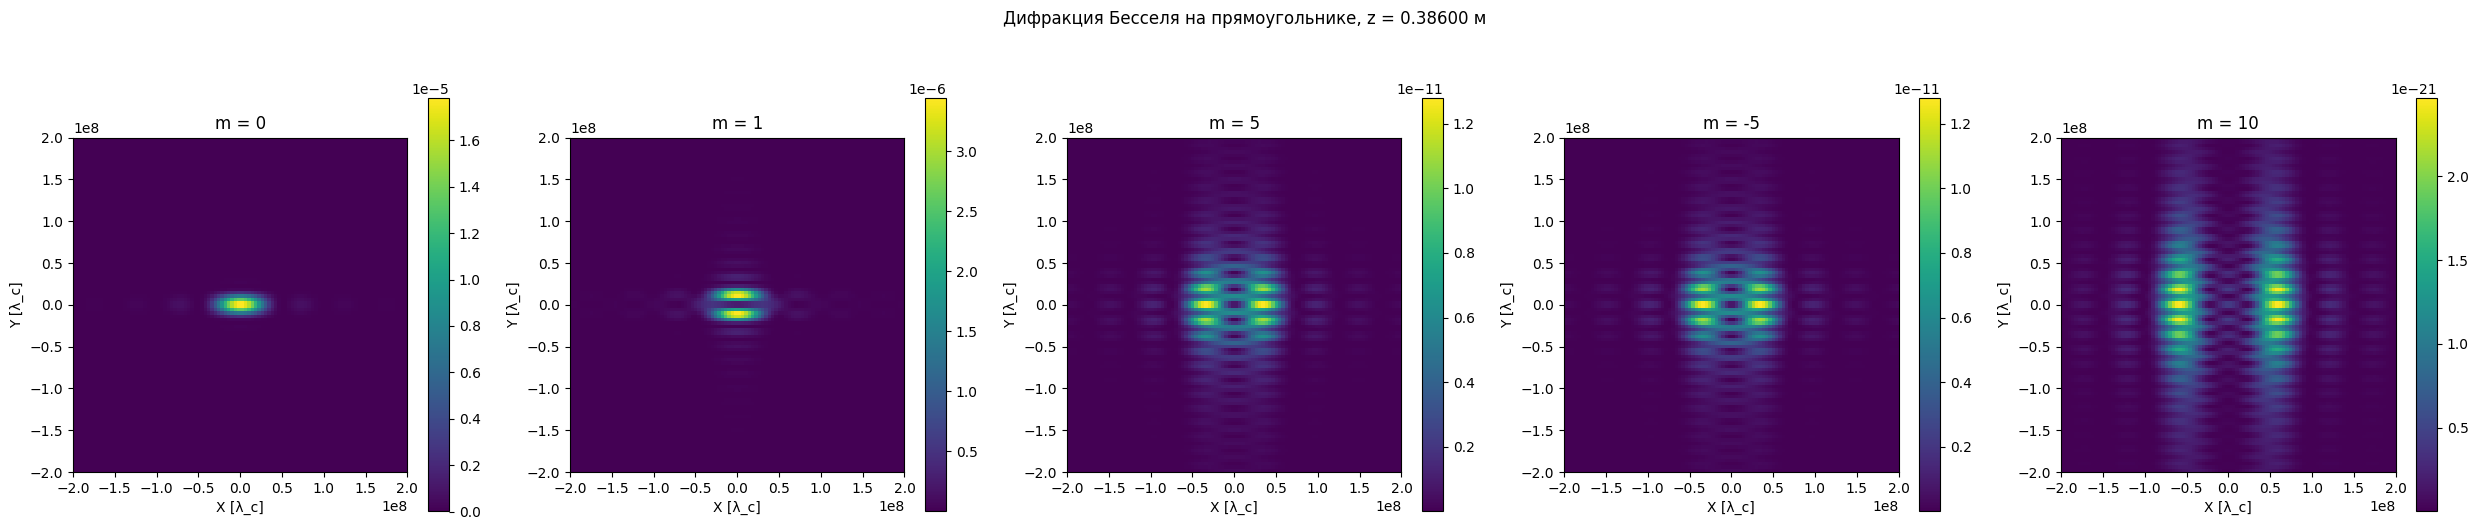

In [21]:
# Расчет для разных значений топологического заряда
m_values = [0, 1, 5, -5, 10]

fig, axes = plt.subplots(1, len(m_values), figsize=(25, 5))
fig.suptitle(f'Дифракция Бесселя на прямоугольнике, z = {z*386e-15:.5f} м', y=1.05)

for idx, m in enumerate(m_values):
    intensity = compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m, N_samples)
    im = axes[idx].imshow(intensity, extent=[-b, b, -b, b], cmap='viridis')
    axes[idx].set_title(f"m = {m}")
    axes[idx].set_xlabel("X [λ_c]")
    axes[idx].set_ylabel("Y [λ_c]")
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

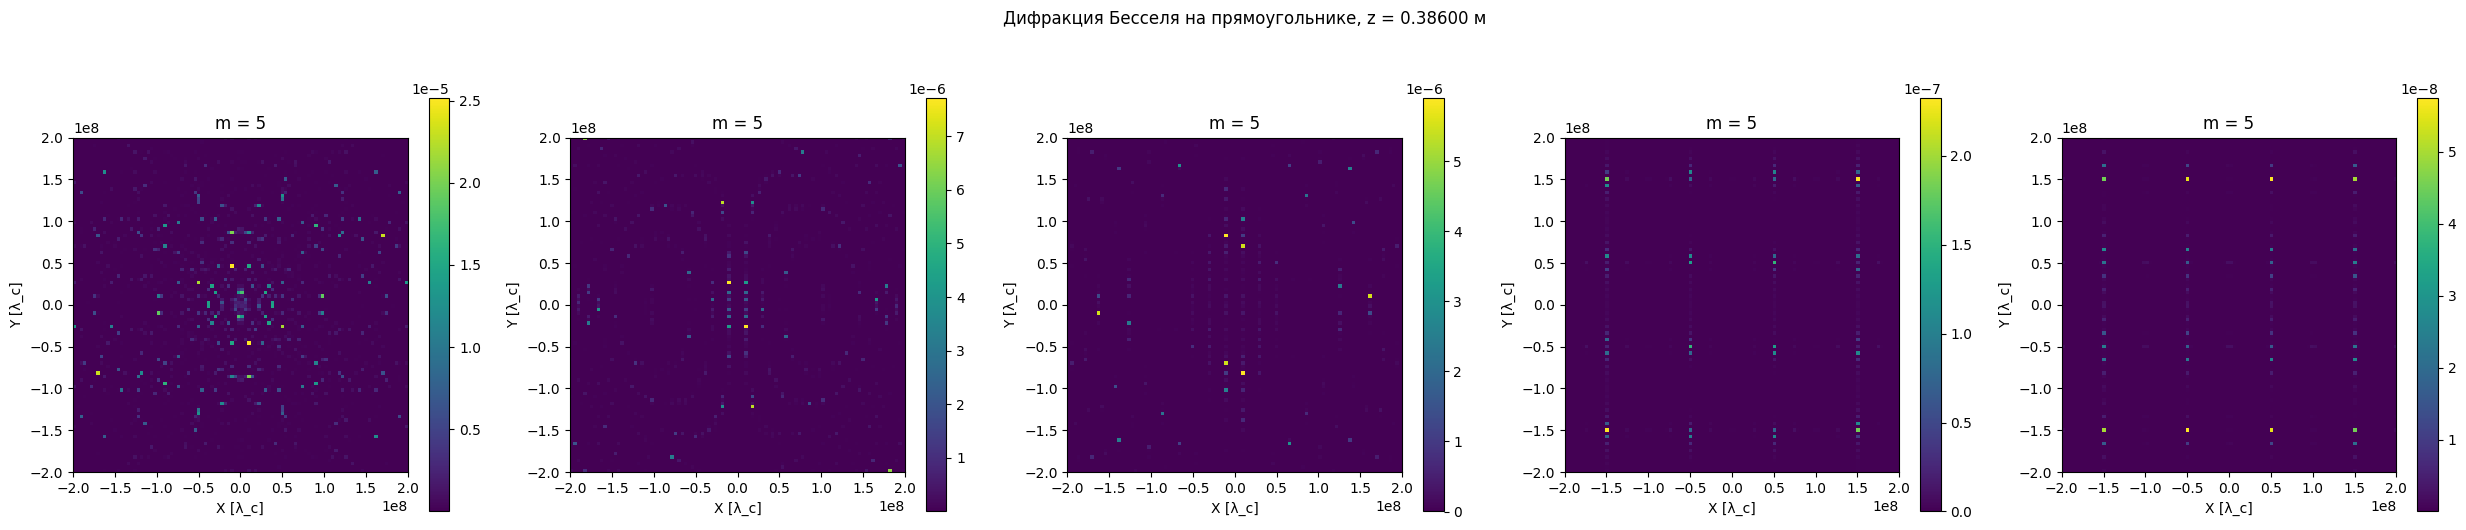

In [22]:
# Расчет для разных значений топологического заряда
m = 5
z_values = [1e8, 5e8, 1e9, 5e9, 1e10]

fig, axes = plt.subplots(1, len(z_values), figsize=(25, 5))
fig.suptitle(f'Дифракция Бесселя на прямоугольнике, z = {z*386e-15:.5f} м', y=1.05)

for idx, z in enumerate(z_values):
    intensity = compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m, N_samples)
    im = axes[idx].imshow(intensity, extent=[-b, b, -b, b], cmap='viridis')
    axes[idx].set_title(f"m = {m}")
    axes[idx].set_xlabel("X [λ_c]")
    axes[idx].set_ylabel("Y [λ_c]")
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

#Бесселев пучок на звезде

In [23]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from math import sqrt, cos, radians

def star_vertices(R=1.0, r=0.4, center=(0,0)):
    """Генерирует вершины пятиконечной звезды"""
    angles = np.linspace(0, 2*np.pi, 10, endpoint=False)
    vertices = []
    for i, angle in enumerate(angles):
        radius = R if i%2 == 0 else r  # Чередование радиусов
        x = radius * np.cos(angle) + center[0]
        y = radius * np.sin(angle) + center[1]
        vertices.append([x, y])
    return np.array(vertices)

def point_inside_star(x, y, vertices):
    """Проверка принадлежности точки звезде"""
    # Преобразуем координаты в плоский массив точек (N, 2)
    points = np.column_stack([x.ravel(), y.ravel()])
    polygon = Path(vertices)
    mask = polygon.contains_points(points)
    return mask.reshape(x.shape)  # Возвращаем маску исходной формы

def angular_part(x, y, m):
    """Вычисляет угловую часть e^{imφ} в декартовых координатах"""
    rho = np.sqrt(x**2 + y**2)
    if m >= 0:
        return (x + 1j*y)**m / (rho**m if m != 0 else 1)
    else:
        return (x - 1j*y)**abs(m) / (rho**abs(m))

def compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m_target, N_samples=100):
    """Вычисление дифракции Бесселя для звездообразной апертуры (исправлено)"""
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)

    x_ap, y_ap = np.meshgrid(
        np.linspace(x_min, x_max, N_samples),
        np.linspace(y_min, y_max, N_samples)
    )

    # Получаем маску правильной формы (N_samples, N_samples)
    mask = point_inside_star(x_ap, y_ap, vertices)

    # Выбираем точки внутри звезды
    x_p = x_ap[mask]
    y_p = y_ap[mask]

    dx = (x_max - x_min) / (N_samples - 1)
    dy = (y_max - y_min) / (N_samples - 1)

    R = np.sqrt(z**2 + (X - x_p[:, None, None])**2 + (Y - y_p[:, None, None])**2)
    R = np.where(R < 1e-10, 1e-10, R)

    kappa = np.sqrt(k**2 - k_z**2)
    angular_part_val = angular_part(x_p, y_p, m_target)
    bessel_part = jv(abs(m_target), kappa * np.sqrt(x_p**2 + y_p**2))
    exp_part = np.exp(1j * k * R)
    factor = (1j*k - 1/R) * z/R + 1j*k_z

    psi = np.sum(
        bessel_part[:, None, None] *
        angular_part_val[:, None, None] *
        exp_part *
        factor / (4 * np.pi * R) * dx * dy,
        axis=0
    )

    return np.abs(psi)**2

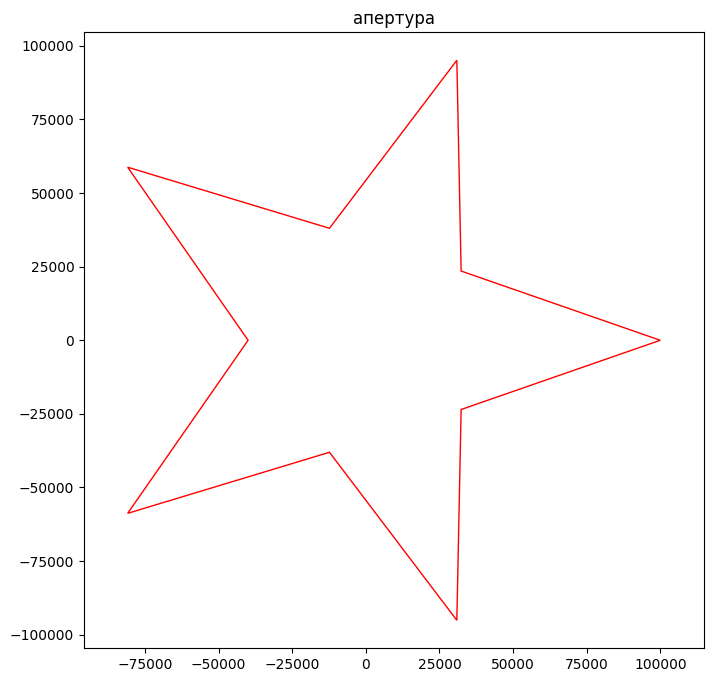

In [24]:
# Параметры расчета
me = 0.511e6           # масса электрона (эВ)
E_k = 300e3            # кинетическая энергия (эВ)
E = 1 + E_k / me       # полная энергия
k = sqrt(E**2 - 1)     # волновой вектор
theta = 0.0001         # угол раствора (рад)
k_z = k * np.cos(theta) # продольная компонента волнового вектора

# Параметры звезды
R = 1e5                # Внешний радиус
r = 0.4e5              # Внутренний радиус
z = 1e12               # расстояние до экрана
b = 3e8              # размер расчетной области
N_xy = 128             # число точек в сетке наблюдения
N_samples = 128        # число точек интегрирования по апертуре

m_values = [0, 1, 5, -5, 10]

# Сетка наблюдения
x = np.linspace(-b, b, N_xy)
y = np.linspace(-b, b, N_xy)
X, Y = np.meshgrid(x, y)

# Вершины звезды и визуализация
vertices = star_vertices(R, r)
plt.figure(figsize=(8,8))
plt.gca().add_patch(plt.Polygon(vertices, fill=None, edgecolor='red'))
plt.title("апертура")
plt.axis('equal')
plt.show()

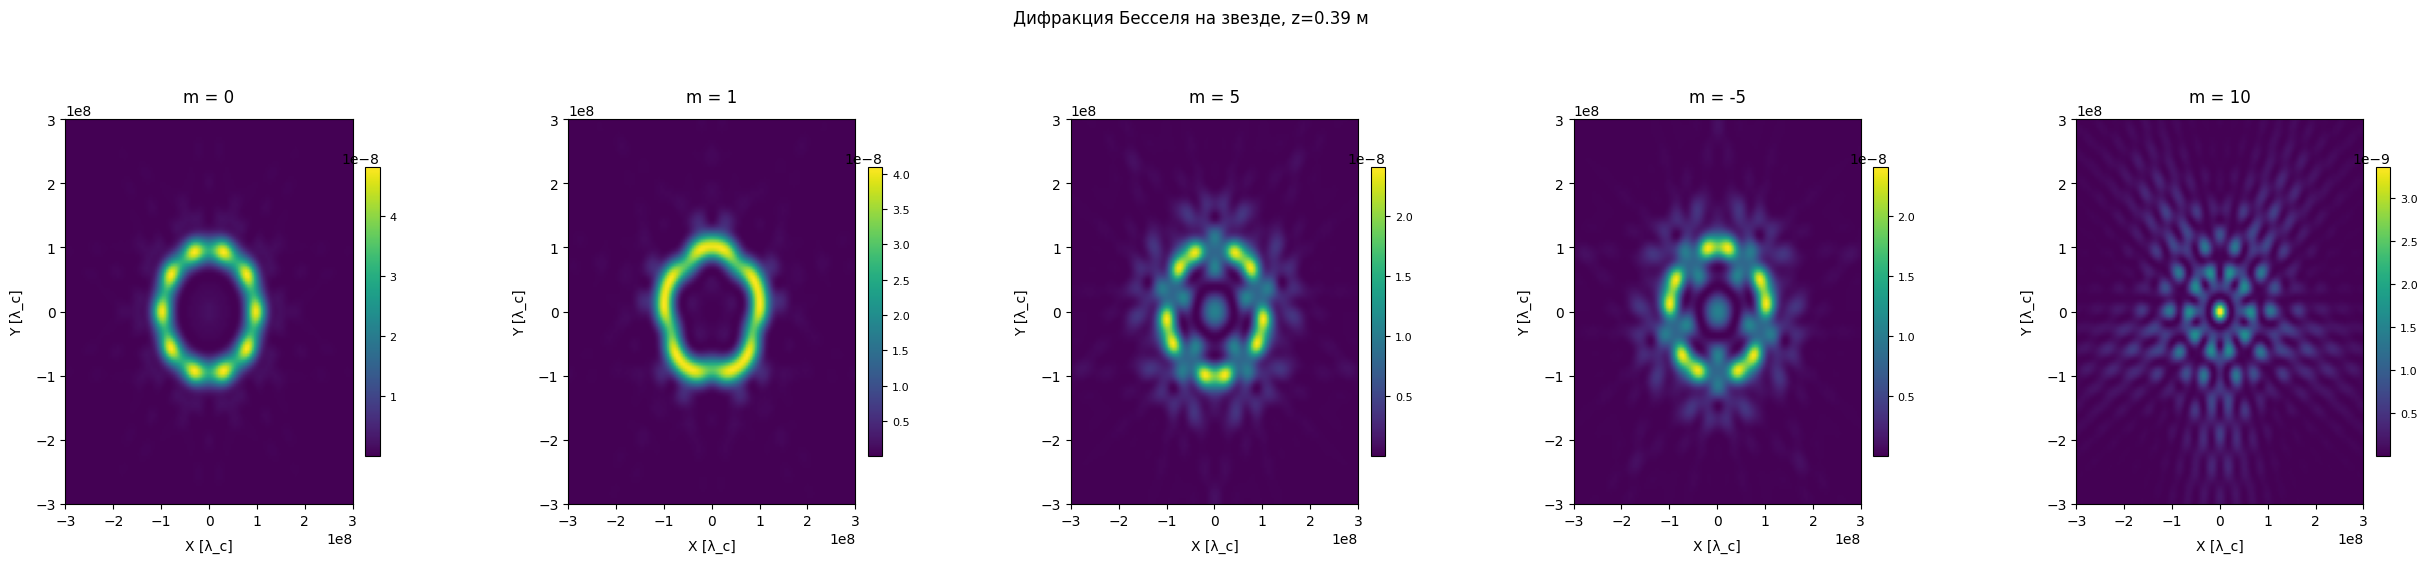

In [25]:
fig, axes = plt.subplots(1, len(m_values), figsize=(30, 5))
fig.suptitle(f'Дифракция Бесселя на звезде, z={z*386e-15:.2f} м', y=1.1)
plt.subplots_adjust(wspace=0.6)

for idx, m in enumerate(m_values):
    intensity = compute_bessel_diffraction(vertices, X, Y, z, k, k_z, m, N_samples)

    im = axes[idx].imshow(
        intensity,
        extent=[-b, b, -b, b],
        cmap='viridis',
        aspect='auto'
    )

    # Настройка осей и заголовков
    axes[idx].set_title(f"m = {m}", pad=12)
    axes[idx].set_xlabel("X [λ_c]", labelpad=8)
    axes[idx].set_ylabel("Y [λ_c]", labelpad=8)

    # Добавляем цветовую шкалу с фиксированным размером
    cbar = plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

plt.show()

# Бесселев пучок на круге/кольце

In [26]:
def r(x, y, z, phi, a):
    return np.sqrt(z**2 + x**2 + y**2 + a**2 - 2*a*(x*np.cos(phi) + y*np.sin(phi)))

def f(x, y, z, phi, a, k, k_z, m_target):
    # Вычисляем r с учетом размерности a
    r_val = r(x, y, z, phi, a)  # Функция r уже должна корректно обрабатывать массив a
    # Bessel function of the first kind (массив a учитывается через sqrt)
    jv_val = jv(m_target, np.sqrt(k**2 - k_z**2) * a)
    # Экспоненциальный множитель
    exp_val = np.exp(1j * k * r_val)
    # Обратное значение r для вычисления знаменателя
    denom = 1 / r_val
    # Основной множитель (учет массивов размерностей)
    factor = (1j * k - denom) * (z * denom) + 1j * k_z
    # Итоговое значение (все операции поддерживают broadcasting)
    return jv_val * exp_val * denom * factor

def compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target):
    # Генерируем массив углов phi
    phi_vals = np.linspace(0, 2 * np.pi, N_phi, endpoint=False)
    # Преобразуем массив 'a' так, чтобы учесть его как дополнительное измерение
    # a имеет размер (N_a,), поэтому добавляем ось для совместимости с X, Y
    a = a[:, None,None,None]  # Превращаем a в форму (N_a, 1, 1, 1)
    # Вызываем функцию f для всех значений a одновременно
    f_phi = f(
        X[None, :, :, None],  # Добавляем ось в X: (N_xy, N_xy) -> (1, N_xy, N_xy, 1)
        Y[None, :, :, None],  # Добавляем ось в Y: (N_xy, N_xy) -> (1, N_xy, N_xy, 1)
        z,                    # z — скаляр, остаётся без изменений
        phi_vals[None, None, None, :],  # Превращаем phi в форму (1, 1, 1, N_phi)
        a,                    # a теперь имеет форму (N_a, 1, 1, 1)
        k, k_z, m_target
    )

    # Вычисляем FFT по углу phi (последняя ось, axis=-1)
    f_hat = np.fft.fft(f_phi, axis=3)

    # Вычисляем частотные индексы
    freq = np.fft.fftfreq(N_phi, d=(2 * np.pi / N_phi)) * 2 * np.pi

    # Находим индекс частоты, соответствующей m_target
    m_index = np.argmin(np.abs(freq - m_target))

    # Извлекаем компоненту с индексом m_target
    # f_hat имеет размер (N_a, N_xy, N_xy, N_phi), берём срез по последней оси
    return f_hat[:, :, :, m_index] * (2 * np.pi / N_phi)

In [27]:
me = 0.511e6
E_k = 300e3         # 300[kEv]
E = 1 + E_k/me
k = np.sqrt(E**2-1)      # k [me]

theta = 0.001  # угол раствора
k_z = k*np.cos(theta)
m_target = 10
k_t = k*theta            # kappa [me]
print('ro:',m_target/k_t)
#############################

z = 1e12                 # distance  [1/me]
b = 5e9               # grid  [1/me]


x_min, x_max = -b, b
y_min, y_max = -b, b

##############################

# Number of sample points in x and y
N_xy = 100              # много не надо

# Create the sample points in x and y
x = np.linspace(x_min, x_max, N_xy)
y = np.linspace(y_min, y_max, N_xy)
X, Y = np.meshgrid(x, y)

# Number of sample points for phi
N_phi = 128  # Increase this for better accuracy of the FFT

ro: 8114.178273675307


In [28]:
N_a = 100

a = np.linspace(0, 1e6, N_a)            # radius
delta_a = a[1] - a[0]

In [29]:
tm1 = tm()
m_target = 0

# Используем einsum для оптимизации операций
intermediate = compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target)
I_k1 = np.abs(np.einsum('i,ijk->jk', a * delta_a / (4 * np.pi), intermediate))**2

# I_k1 = np.abs(
#     np.sum(
#         a[:,None,None] * delta_a * compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target) / (4 * np.pi),
#         axis=0
#     )
# )**2
tm2 = tm()
print(tm2-tm1)

m_target = 2
intermediate = compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target)
I_k2 = np.abs(np.einsum('i,ijk->jk', a * delta_a / (4 * np.pi), intermediate))**2

# I_k2 = np.abs(
#     np.sum(
#         a[:,None,None] * delta_a * compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target) / (4 * np.pi),
#         axis=0
#     )
# )**2
tm3 = tm()
print(tm3-tm2)

m_target = 10
intermediate = compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target)
I_k3 = np.abs(np.einsum('i,ijk->jk', a * delta_a / (4 * np.pi), intermediate))**2

# I_k3 = np.abs(
#     np.sum(
#         a[:,None,None] * delta_a * compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target) / (4 * np.pi),
#         axis=0
#     )
# )**2
tm4 = tm()
print(tm4-tm3)

m_target = 5
intermediate = compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target)
I_k4 = np.abs(np.einsum('i,ijk->jk', a * delta_a / (4 * np.pi), intermediate))**2

# I_k3 = np.abs(
#     np.sum(
#         a[:,None,None] * delta_a * compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target) / (4 * np.pi),
#         axis=0
#     )
# )**2
tm5 = tm()
print(tm5-tm4)

m_target = -5
intermediate = compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target)
I_k5 = np.abs(np.einsum('i,ijk->jk', a * delta_a / (4 * np.pi), intermediate))**2

# I_k3 = np.abs(
#     np.sum(
#         a[:,None,None] * delta_a * compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target) / (4 * np.pi),
#         axis=0
#     )
# )**2
tm6 = tm()
print(tm6-tm5)

7.808762073516846
6.05886697769165
3.8092539310455322
5.335050106048584
6.308605909347534


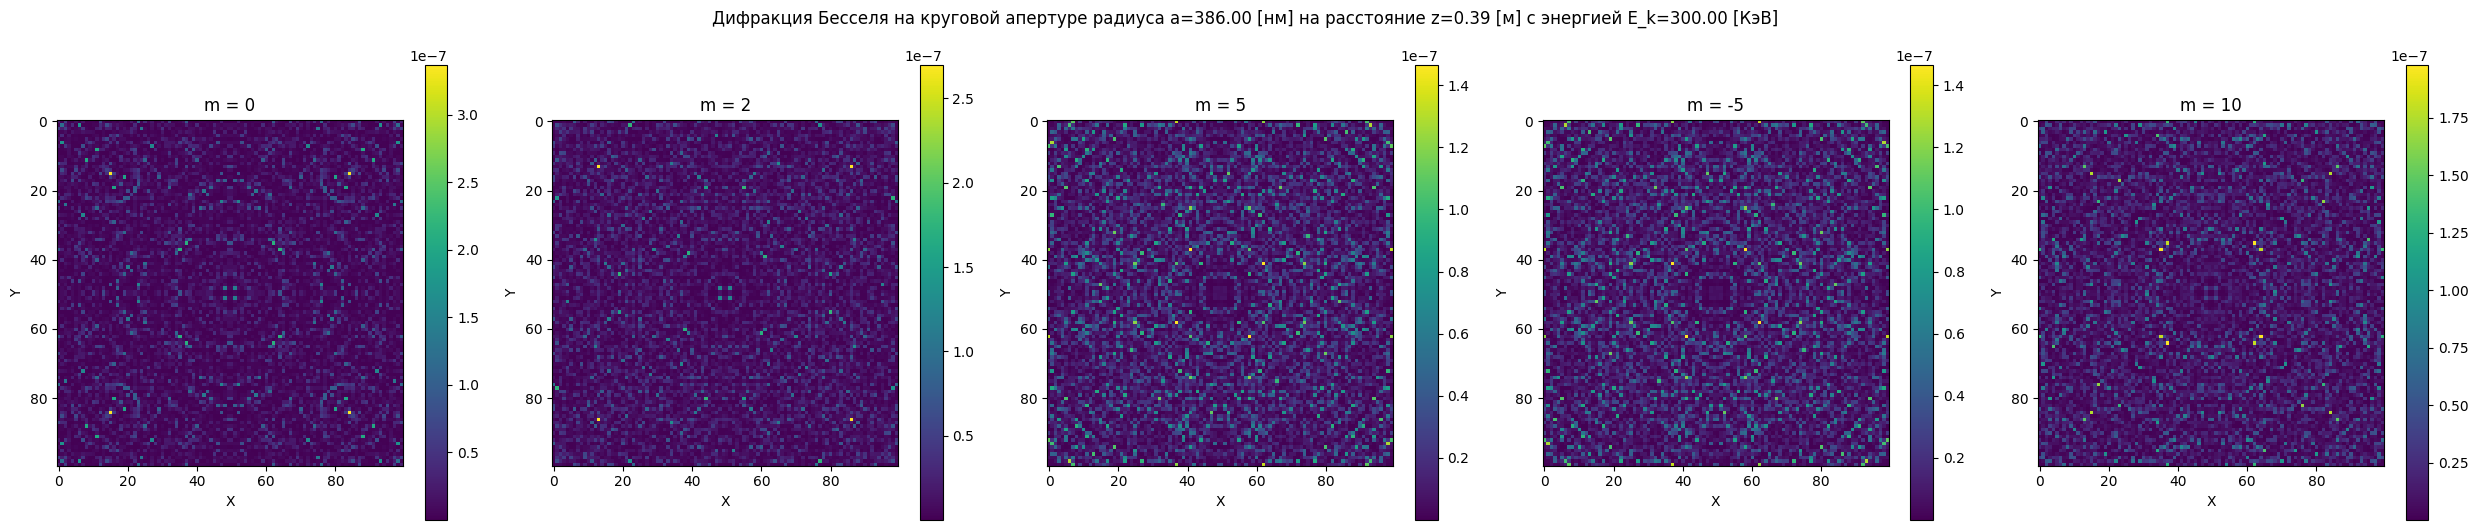

In [30]:
# Создаем фигуру с тремя подграфиками (1 строка, 3 столбца)
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 1 строка, 3 столбца, общий размер фигуры 15x5

# Отображаем первый график (fig1) в первом подграфике
axes[0].imshow(I_k1, extent=[x_min, x_max, y_min, y_max], origin='lower')
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_title("m = 0")
plt.colorbar(axes[0].imshow(I_k1, cmap='viridis'), ax=axes[0])

# Отображаем второй график (fig2) во втором подграфике
axes[1].imshow(I_k2, extent=[x_min, x_max, y_min, y_max], origin='lower')
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].set_title("m = 2")
plt.colorbar(axes[1].imshow(I_k2, cmap='viridis'), ax=axes[1])

# Отображаем третий график (fig3) в третьем подграфике
axes[2].imshow(I_k4, extent=[x_min, x_max, y_min, y_max], origin='lower')
axes[2].set_xlabel("X")
axes[2].set_ylabel("Y")
axes[2].set_title("m = 5")
plt.colorbar(axes[2].imshow(I_k4, cmap='viridis'), ax=axes[2])

# Отображаем четвертый график (fig4) в четвертом подграфике
axes[3].imshow(I_k5, extent=[x_min, x_max, y_min, y_max], origin='lower')
axes[3].set_xlabel("X")
axes[3].set_ylabel("Y")
axes[3].set_title("m = -5")
plt.colorbar(axes[3].imshow(I_k5, cmap='viridis'), ax=axes[3])

# Отображаем четвертый график (fig4) в четвертом подграфике
axes[4].imshow(I_k3, extent=[x_min, x_max, y_min, y_max], origin='lower')
axes[4].set_xlabel("X")
axes[4].set_ylabel("Y")
axes[4].set_title("m = 10")
plt.colorbar(axes[4].imshow(I_k3, cmap='viridis'), ax=axes[4])

# Настраиваем расположение подграфиков
plt.tight_layout()
fig.suptitle(f'Дифракция Бесселя на круговой апертуре радиуса a={1e6*386e-6:.2f} [нм] на расстояние z={z*386e-15:.2f} [м] с энергией E_k={E_k*1e-3:.2f} [КэВ]', y=1.05)
# Показываем график
plt.show()

# Бессель на круге

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.integrate import quad_vec
from scipy.special import jv

# ==========================
# 1. ФУНКЦИИ
# ==========================
def compute_f_m(a, X, Y, z, k, k_z, N_phi, m_target):
    """
    Возвращает комплексное поле ψ_m(a; x,y) = ∫₀^{2π} ψ_inc(a, φ') · (e^{i k R}/R) · [(i k - 1/R)*(z/R) + i k_z] dφ',
    где ψ_inc(a, φ') = J_{|m|}(sqrt(k^2 - k_z^2) · a) · e^{i m φ'} и
          R = sqrt(z^2 + (x - a cosφ')^2 + (y - a sinφ')^2).

    Параметры:
      - a        : радиус апертуры (скаляр)
      - X, Y     : двумерные массивы координат экрана (shape = (N_xy, N_xy))
      - z, k     : расстояние до экрана и полное волновое число
      - k_z      : продольная компонента волнового числа
      - N_phi    : число точек для дискретизации φ (для FFT)
      - m_target : топологический заряд (integer, может быть отрицательным или положительным)

    Возвращает:
      - f_m(a; X, Y) : двумерный комплексный массив (shape = (N_xy, N_xy))

    Реализация:
      1) Строим сетку φ ∈ [0, 2π) с N_phi точками.
      2) Для каждой точки φ вычисляем
           R = sqrt(z^2 + (X - a·cosφ)^2 + (Y - a·sinφ)^2),
           затем f(a,x,y,φ) = J_{|m|}(κ·a) · e^{i m φ} · [e^{i k R}/R] · [(i k - 1/R)*(z/R) + i k_z] · a
         где κ = sqrt(k^2 - k_z^2).
      3) Берём FFT по φ-ось (axis = –1) и извлекаем «m_target»-ю гармонику.
      4) Домножаем на (2π/N_phi), чтобы учесть шаг dφ = 2π/N_phi.

    Это полностью соответствует подходу из вашего файла `diffraction_of_an_electron.py` :contentReference[oaicite:1]{index=1}.
    """
    # 1) Задаём сетку φ
    phi_vals = np.linspace(0, 2*np.pi, N_phi, endpoint=False)      # shape = (N_phi,)
    dphi = 2*np.pi / N_phi

    # 2) Поперечное волновое число κ
    kappa = np.sqrt(k**2 - k_z**2)

    # 3) Предвычисляем J_{|m|}(κ·a) (скаляр, т.к. здесь a – константа)
    Jm_ka = jv(abs(m_target), kappa * a)                            # скаляр

    # 4) Для broadcasting: расширяем X,Y до (N_xy, N_xy, 1) и φ до (1, 1, N_phi)
    X3 = X[:, :, None]                                               # shape = (N_xy, N_xy, 1)
    Y3 = Y[:, :, None]                                               # shape = (N_xy, N_xy, 1)
    phi3 = phi_vals[None, None, :]                                   # shape = (1, 1, N_phi)

    # 5) Вычисляем координаты точки апертуры (x', y') = (a cosφ, a sinφ)
    x_pr = a * np.cos(phi3)                                          # shape = (1, 1, N_phi)
    y_pr = a * np.sin(phi3)                                          # shape = (1, 1, N_phi)

    # 6) Расстояние R(x,y; a, φ) = sqrt(z^2 + (X - x')^2 + (Y - y')^2)
    dx = X3 - x_pr                                                   # (N_xy, N_xy, N_phi)
    dy = Y3 - y_pr                                                   # (N_xy, N_xy, N_phi)
    R  = np.sqrt(z**2 + dx**2 + dy**2)                               # (N_xy, N_xy, N_phi)

    # 7) Вычисляем ядро: exp(i k R)/R
    exp_ikr = np.exp(1j * k * R)                                     # (N_xy, N_xy, N_phi)
    inv_R   = 1.0 / R                                                # (N_xy, N_xy, N_phi)

    # 8) Префактор Кирхгофа: (i k - 1/R)*(z/R) + i k_z
    pref = (1j * k - inv_R) * (z * inv_R) + 1j * k_z                 # (N_xy, N_xy, N_phi)

    # 9) Входное поле ψ_inc = J_{|m|}(κ a) · e^{i m φ}
    #    Так как Jm_ka — скаляр, просто домножаем на e^{i m φ} (shape=(N_phi,))
    exp_imphi = np.exp(1j * m_target * phi_vals)                     # (N_phi,)
    exp_mphi3 = exp_imphi[None, None, :]                             # (1, 1, N_phi)

    # 10) Собираем полный f(a; x,y, φ) = Jm_ka · e^{i m φ} · [exp(i k R)/R] · pref · a
    #     При этом множитель „a” мы оставляем внутри, чтобы корректно учесть Jacobian при интегрировании по a.
    f_phi = Jm_ka * exp_mphi3 * (exp_ikr * inv_R * pref) * a         # shape = (N_xy, N_xy, N_phi)

    # 11) Взятие FFT по оси φ (axis = –1) → получаем массив shape = (N_xy, N_xy, N_phi)
    f_hat = fft(f_phi, axis=-1)                                      # (N_xy, N_xy, N_phi)

    # 12) Находим индекс, соответствующий m_target-ой гармонике
    freq = fftfreq(N_phi, d=dphi) * 2 * np.pi                        # (N_phi,)
    m_index = np.argmin(np.abs(freq - m_target))

    # 13) Извлекаем эту компоненту и домножаем на шаг dφ, т.к. FFT без нормировки:
    #     ∫₀²π f(a,φ) e^{-i m φ} dφ ≈ f_hat[..., m_index] · dφ
    f_m = f_hat[..., m_index] * dphi                                  # (N_xy, N_xy), комплекс

    return f_m  # ψ_m(a; x,y)

def compute_bessel_diffraction_circle_quad(
    X, Y,                   # двумерные массивы экранных координат (shape=(N_xy,N_xy))
    z,                      # расстояние до экрана
    k,                      # полное волновое число
    k_z,                    # продольная компонента волнового числа
    m,                      # топологическое число Бесселева пучка
    a_max,                  # максимальный радиус апертуры
    N_phi,                  # число точек для φ внутри compute_f_m
    epsabs=1e-5, epsrel=1e-5
):
    """
    Обёртка, которая считает
      ψ(x,y) = ∫₀^{a_max} [ψ_m(a; x,y)] da  / (4π),
    где ψ_m(a; x,y) возвращает compute_f_m,
    а интегрирование по a делается через quad_vec.
    Возвращает двумерную матрицу I_2D = |ψ(x,y)|^2.
    """
    # 1) Определяем вспомогательную функцию для передачи quad_vec:
    def integrand(a_scalar):
        # a_scalar — скаляр. Возвращаем двумерный массив ψ_m(a_scalar; X,Y).
        return compute_f_m(a_scalar, X, Y, z, k, k_z, N_phi, m)

    # 2) Запускаем quad_vec по a ∈ [0, a_max].
    #    На выходе получаем комплексное ψ_total(x,y) (shape=(N_xy,N_xy)).
    psi_total, _ = quad_vec(
        integrand,
        0.0, a_max,
        epsabs=epsabs, epsrel=epsrel
    )
    # 3) Учитываем фактор 1/(4π):
    psi_total *= 1.0 / (4.0 * np.pi)

    # 4) Возвращаем интенсивность:
    I_2D = np.abs(psi_total)**2
    return I_2D

In [32]:
# ==========================
# 2. ПАРАМЕТРЫ
# ==========================
# Физические параметры
me    = 0.511e6           # масса электрона (эВ)
E_k   = 300e3             # кинетическая энергия (эВ)
E     = 1 + E_k / me      # полная энергия (безразмерная)
k     = np.sqrt(E**2 - 1) # волновое число
theta = 0.0001            # угол раствора (рад)
k_z   = k * np.cos(theta) # продольная компонента p_z

# Геометрия апертуры и экрана
a_max = 1e6            # радиус круглой апертуры
z = 1e12           # расстояние до экрана
b = 5e9           # полурадиус расчетной области на экране

# Численные параметры
N_xy  = 100               # число точек в сетке экрана (по x и y)
N_phi = 100                # число точек для интеграла по φ внутри compute_f_m

# Сетка экрана (x,y)
x = np.linspace(-b, b, N_xy)
y = np.linspace(-b, b, N_xy)
X, Y = np.meshgrid(x, y)

# Топологические числа m, по которым строим
m_values = [0, 1, 5, -5, 10]

In [ ]:
# ==========================
# 3. ВИЗУАЛИЗАЦИЯ
# ==========================
fig, axes = plt.subplots(1, len(m_values), figsize=(25, 5))
fig.suptitle(f'Дифракция Бесселя на круглой щели (quad_vec), z = {z*386e-15:.5f} м', y=1.02)

for idx, m in enumerate(m_values):
    intensity = compute_bessel_diffraction_circle_quad(
        X, Y, z, k, k_z, m, a_max, N_phi,
        epsabs=1e-5, epsrel=1e-5
    )
    im = axes[idx].imshow(
        intensity,
        extent=[-b, b, -b, b],
        cmap='viridis',
        origin='lower'
    )
    axes[idx].set_title(f"m = {m}")
    axes[idx].set_xlabel("X [λ_c]")
    if idx == 0:
        axes[idx].set_ylabel("Y [λ_c]")
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv

# ==========================
# 1. ФУНКЦИИ
# ==========================
def compute_bessel_paraxial_analytic(
    X, Y,             # двумерные массивы экранных координат (shape=(N_xy, N_xy))
    z,                # расстояние до экрана
    k,                # полное волновое число
    k_z,              # продольная компонента волнового числа
    m,                # топологический заряд Бесселева пучка
    a                 # радиус круглой апертуры
):
    """
    Возвращает двумерную матрицу интенсивности I_2D = |psi|^2
    по аналитической формуле параксиальной (Фраунгофер) дифракции на круглой щели:

    psi(rho) ∝ (-i)^m (e^{i k z}/(i k z)) e^{i k rho^2/(2z)}
             * [ a * (alpha * J_m(u a) J_{m+1}(alpha a) - u J_{m+1}(u a) J_m(alpha a))
                 / (alpha^2 - u^2) ]
    где:
      rho = sqrt(X^2 + Y^2),
      u = sqrt(k^2 - k_z^2),
      alpha = (k rho) / z.
    """
    # Поперечное волновое число (κ)
    kappa = np.sqrt(k**2 - k_z**2)

    # Координата rho в плоскости экрана
    rho = np.sqrt(X**2 + Y**2)

    # Параксиальное alpha
    alpha = (k * rho) / z

    # Аргументы Bessel
    u = kappa
    arg_u_a = u * a
    arg_alpha_a = alpha * a

    # Вычисляем Bessel J_m(u a), J_{m+1}(u a), J_m(alpha a), J_{m+1}(alpha a)
    Jm_u_a = jv(abs(m), arg_u_a)
    Jm1_u_a = jv(abs(m)+1, arg_u_a)
    Jm_alpha_a = jv(abs(m), arg_alpha_a)
    Jm1_alpha_a = jv(abs(m)+1, arg_alpha_a)

    # Вычисляем числитель и знаменатель
    numer = alpha * Jm_u_a * Jm1_alpha_a - u * Jm1_u_a * Jm_alpha_a
    denom = alpha**2 - u**2

    # Чтобы избежать деления на ноль, добавим небольшой eps там, где denom == 0
    eps = 1e-16
    denom = np.where(np.abs(denom) < eps, eps, denom)

    # Фактор a*(...) / denom
    frac = a * numer / denom

    # Фаза: (-i)^m * e^{i k z}/(i k z) * e^{i k rho^2/(2z)}
    pref_factor = ((-1j)**m) * np.exp(1j * k * z) / (1j * k * z)
    phase_quad = np.exp(1j * (k * rho**2) / (2 * z))

    psi = pref_factor * phase_quad * frac

    # Интенсивность
    I_2D = np.abs(psi)**2
    return I_2D

In [ ]:
# ==========================
# 2. ПАРАМЕТРЫ
# ==========================
# Физические параметры
me    = 0.511e6            # масса электрона (эВ)
E_k   = 300e3              # кинетическая энергия (эВ)
E     = 1 + E_k / me       # полная энергия (безразмерная)
k     = np.sqrt(E**2 - 1)  # волновое число
theta = 0.0001             # угол раствора (рад)
k_z   = k * np.cos(theta)  # продольная компонента

# Геометрия апертуры и экрана
a        = 1e6             # радиус круглой щели
z        = 1e12            # расстояние до экрана
b        = 5e7            # полурадиус расчетной области на экране

# Численные параметры
N_xy     = 300             # число точек в сетке экрана (по x и y)

# Сетка экрана (x, y)
x = np.linspace(-b, b, N_xy)
y = np.linspace(-b, b, N_xy)
X, Y = np.meshgrid(x, y)

# Топологические числа m, которые хотим посчитать
m_values = [0, 1, 5, -5, 10]

In [ ]:
# ==========================
# 3. ВИЗУАЛИЗАЦИЯ
# ==========================
fig, axes = plt.subplots(1, len(m_values), figsize=(25, 5))
fig.suptitle(f'Аналитическая фраунгоферная дифракция Бесселя на круглой щели, z = {z*386e-15:.5f} м', y=1.02)

for idx, m in enumerate(m_values):
    intensity = compute_bessel_paraxial_analytic(X, Y, z, k, k_z, m, a)
    im = axes[idx].imshow(
        intensity,
        extent=[-b, b, -b, b],
        cmap='viridis',
        origin='lower'
    )
    axes[idx].set_title(f"m = {m}")
    axes[idx].set_xlabel("X [λ₀]")
    if idx == 0:
        axes[idx].set_ylabel("Y [λ₀]")
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
